<a href="https://colab.research.google.com/github/atanasiusps/Machine-Learning-Enrichment_Task/blob/main/Chapter-16/Chapter_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CODE REPRODUCTION

Import library

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB:
    %pip install -q -U tensorflow-addons
    %pip install -q -U transformers

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nlp"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


Char-RNN

Splitting a sequence into batches of shuffled windows

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

n_steps = 5
dataset = tf.data.Dataset.from_tensor_slices(tf.range(15))
dataset = dataset.window(n_steps, shift=2, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(n_steps))
dataset = dataset.shuffle(10).map(lambda window: (window[:-1], window[1:]))
dataset = dataset.batch(3).prefetch(1)
for index, (X_batch, Y_batch) in enumerate(dataset):
    print("_" * 20, "Batch", index, "\nX_batch")
    print(X_batch.numpy())
    print("=" * 5, "\nY_batch")
    print(Y_batch.numpy())

____________________ Batch 0 
X_batch
[[6 7 8 9]
 [2 3 4 5]
 [4 5 6 7]]
===== 
Y_batch
[[ 7  8  9 10]
 [ 3  4  5  6]
 [ 5  6  7  8]]
____________________ Batch 1 
X_batch
[[ 0  1  2  3]
 [ 8  9 10 11]
 [10 11 12 13]]
===== 
Y_batch
[[ 1  2  3  4]
 [ 9 10 11 12]
 [11 12 13 14]]


Loading the Data and Preparing the Dataset

In [ ]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



In [ ]:
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [ ]:

tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

In [ ]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [ ]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [ ]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

In [ ]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [ ]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [ ]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(tf.cast(X_batch, tf.int32), depth=max_id), Y_batch)
)

In [ ]:
dataset = dataset.prefetch(1)

In [ ]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 39, 39) (32, 100)


Creating and Training the Model

In [ ]:
import tensorflow as tf
import numpy as np

# Step 1: Download Shakespeare dataset
path_to_file = tf.keras.utils.get_file("shakespeare.txt",
    "https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt")

# Step 2: Load and encode the text
with open(path_to_file, "r", encoding="utf-8") as f:
    text = f.read()

vocab = sorted(set(text))
char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = np.array(vocab)
max_id = len(vocab)

text_as_int = np.array([char2idx[c] for c in text], dtype=np.int32)

# Step 3: Create dataset of character sequences
n_steps = 100  # sequence length
batch_size = 32

def split_input_target(sequence):
    input_seq = sequence[:-1]
    target_seq = sequence[1:]
    return input_seq, target_seq

dataset = tf.data.Dataset.from_tensor_slices(text_as_int)
dataset = dataset.batch(n_steps + 1, drop_remainder=True)
dataset = dataset.map(split_input_target)
dataset = dataset.map(lambda X, Y: (tf.one_hot(X, depth=max_id), Y))
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True).prefetch(1)

# Step 4: Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id], dropout=0.2),
    tf.keras.layers.GRU(128, return_sequences=True, dropout=0.2),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(max_id, activation="softmax"))
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

# Step 5: Train the model
history = model.fit(dataset, epochs=10)


Epoch 1/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 3.1291
Epoch 2/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 2.3472
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 2.1942
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 2.1018
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 2.0396
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 2.0009
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 1.9665
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 1.9398
Epoch 9/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 1.9224
Epoch 10/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 1.9069


Using the Model to Generate Text

In [ ]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [ ]:
X_new = preprocess(["How are yo"])
#Y_pred = model.predict_classes(X_new)
Y_pred = np.argmax(model(X_new), axis=-1)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

'!'

In [ ]:
tf.random.set_seed(42)

tf.random.categorical([[np.log(0.5), np.log(0.4), np.log(0.1)]], num_samples=40).numpy()

array([[0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
        2, 0, 0, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 0, 0, 0, 0]])

In [ ]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [ ]:
tf.random.set_seed(42)

next_char("How are yo", temperature=1)

''

In [ ]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
tf.random.set_seed(42)

print(complete_text("t", temperature=0.2))

t  fk'qy,-j,!
 z


In [ ]:
print(complete_text("t", temperature=1))

t cmuzb.y


In [ ]:
print(complete_text("t", temperature=2))

tpeybmuvkuv
-?q-
 m!debbu
-j!e


Stateful RNN

In [ ]:
tf.random.set_seed(42)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
batch_size = 32
encoded_parts = np.array_split(encoded[:train_size], batch_size)
datasets = []
for encoded_part in encoded_parts:
    dataset = tf.data.Dataset.from_tensor_slices(encoded_part)
    dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_length))
    datasets.append(dataset)
dataset = tf.data.Dataset.zip(tuple(datasets)).map(lambda *windows: tf.stack(windows))
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

In [ ]:
from tensorflow import keras

model = keras.models.Sequential([
    keras.layers.Input(batch_shape=(batch_size, None, max_id)),
    keras.layers.GRU(128, return_sequences=True, stateful=True, dropout=0.2),
    keras.layers.GRU(128, return_sequences=True, stateful=True, dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, activation="softmax"))
])


In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        for layer in self.model.layers:
            if hasattr(layer, 'reset_states'):
                layer.reset_states()


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

history = model.fit(dataset, epochs=50,
                    callbacks=[ResetStatesCallback()])


Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 29s 76ms/step - loss: 3.0491
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - loss: 2.3439
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - loss: 2.1693
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - loss: 2.0745
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 44s 85ms/step - loss: 2.0095
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - loss: 1.9670
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 76ms/step - loss: 1.9339
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 74ms/step - loss: 1.9057
Epoch 9/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 79ms/step - loss: 1.8872
Epoch 10/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - loss: 1.8692
Epoch 11/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 79ms/step - loss: 1.8531
Epoch 12/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 76ms/step - loss: 1.8429
Epoch 13/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - loss: 1.8291
Epoch 14/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 80ms/step - loss: 1.8191
Epoch 15/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 74ms/step - loss: 1.8125
Epoch 16/50
313/313 ━━━━━━━━━━━━━━━━━━━

In [ ]:
stateless_model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [ ]:
stateless_model.build(tf.TensorShape([None, None, max_id]))

In [ ]:
stateless_model.set_weights(model.get_weights())
model = stateless_model

In [ ]:
tf.random.set_seed(42)

print(complete_text("t"))

thing iddidness of a jist jost,
he bear the onest m


Sentiment Analysis

In [ ]:
tf.random.set_seed(42)

In [ ]:
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data()

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

In [ ]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


'<sos> this film was just brilliant casting location scenery story'

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.7893WO_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.7893WO_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.7893WO_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
datasets.keys()

dict_keys([Split('train'), Split('test'), Split('unsupervised')])

In [ ]:
train_size = info.splits["train"].num_examples
test_size = info.splits["test"].num_examples

In [ ]:
train_size, test_size

(25000, 25000)

In [ ]:
for X_batch, y_batch in datasets["train"].batch(2).take(1):
    for review, label in zip(X_batch.numpy(), y_batch.numpy()):
        print("Review:", review.decode("utf-8")[:200], "...")
        print("Label:", label, "= Positive" if label else "= Negative")
        print()

Review: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0 = Negative

Review: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0 = Negative



In [ ]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch

In [ ]:
preprocess(X_batch, y_batch)

(<tf.Tensor: shape=(2, 53), dtype=string, numpy=
 array([[b'This', b'was', b'an', b'absolutely', b'terrible', b'movie',
         b"Don't", b'be', b'lured', b'in', b'by', b'Christopher',
         b'Walken', b'or', b'Michael', b'Ironside', b'Both', b'are',
         b'great', b'actors', b'but', b'this', b'must', b'simply', b'be',
         b'their', b'worst', b'role', b'in', b'history', b'Even',
         b'their', b'great', b'acting', b'could', b'not', b'redeem',
         b'this', b"movie's", b'ridiculous', b'storyline', b'This',
         b'movie', b'is', b'an', b'early', b'nineties', b'US',
         b'propaganda', b'pi', b'<pad>', b'<pad>', b'<pad>'],
        [b'I', b'have', b'been', b'known', b'to', b'fall', b'asleep',
         b'during', b'films', b'but', b'this', b'is', b'usually', b'due',
         b'to', b'a', b'combination', b'of', b'things', b'including',
         b'really', b'tired', b'being', b'warm', b'and', b'comfortable',
         b'on', b'the', b'sette', b'and', b'having', b'j

In [ ]:
from collections import Counter

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

In [ ]:
vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [ ]:

len(vocabulary)

53893

In [ ]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [ ]:

word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}
for word in b"This movie was faaaaaantastic".split():
    print(word_to_id.get(word) or vocab_size)

22
12
11
10000


In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [ ]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [ ]:

def encode_words(X_batch, y_batch):
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)

In [ ]:

for X_batch, y_batch in train_set.take(1):
    print(X_batch)
    print(y_batch)

tf.Tensor(
[[  22   11   28 ...    0    0    0]
 [   6   21   70 ...    0    0    0]
 [4099 6881    1 ...    0    0    0]
 ...
 [  22   12  118 ...  331 1047    0]
 [1757 4101  451 ...    0    0    0]
 [3365 4392    6 ...    0    0    0]], shape=(32, 60), dtype=int64)
tf.Tensor([0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0], shape=(32,), dtype=int64)


In [ ]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
                           mask_zero=True, # not shown in the book
                           input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


782/782 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.6421 - loss: 0.6090
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8363 - loss: 0.3817
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9129 - loss: 0.2361
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9526 - loss: 0.1364
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9580 - loss: 0.1142


In [ ]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs)
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask)
outputs = keras.layers.Dense(1, activation="sigmoid")(z)
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_37']
Received: inputs=Tensor(shape=(None, None))
  warnings.warn(msg)


782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.6492 - loss: 0.6028
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.8422 - loss: 0.3673
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.9211 - loss: 0.2151
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9448 - loss: 0.1438
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9566 - loss: 0.1199


Reusing Pretrained Embeddings

In [ ]:

tf.random.set_seed(42)

In [ ]:
TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

# Wrap hub.KerasLayer in a custom Keras Layer
class HubTextEmbedding(layers.Layer):
    def __init__(self, hub_url, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, trainable=True)

    def call(self, inputs):
        return self.hub_layer(inputs)

# Build the model using Functional API
inputs = keras.Input(shape=(), dtype=tf.string)
x = HubTextEmbedding("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1")(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
for dirpath, dirnames, filenames in os.walk(TFHUB_CACHE_DIR):
    for filename in filenames:
        print(os.path.join(dirpath, filename))

./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe.descriptor.txt
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/saved_model.pb
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.index
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/variables/variables.data-00000-of-00001
./my_tfhub_cache/82c4aaf4250ffb09088bd48368ee7fd00e5464fe/assets/tokens.txt


In [ ]:
class HubTextEmbedding(layers.Layer):
    def __init__(self, hub_url, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, trainable=True)

    def call(self, inputs):
        with tf.device("/CPU:0"):
            return self.hub_layer(inputs)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Load data
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_set = datasets["train"].batch(32).prefetch(tf.data.AUTOTUNE)

# Text vectorization layer
vectorizer = layers.TextVectorization(max_tokens=10000, output_sequence_length=100)
text_ds = datasets["train"].map(lambda x, y: x)
vectorizer.adapt(text_ds.batch(64))

# Model
model = keras.Sequential([
    vectorizer,
    layers.Embedding(input_dim=10000, output_dim=128),
    layers.GlobalAveragePooling1D(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(train_set, epochs=5)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7248 - loss: 0.5340
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8658 - loss: 0.3085
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8919 - loss: 0.2593
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9082 - loss: 0.2280
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9203 - loss: 0.2042


Automatic Translation

In [ ]:
tf.random.set_seed(42)

In [ ]:
vocab_size = 100
embed_size = 10

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

vocab_size = 10000
embed_size = 128
max_len = 100

# Encoder
encoder_inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(vocab_size, embed_size)(encoder_inputs)
encoder_outputs, state_h, state_c = layers.LSTM(512, return_state=True)(x)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = keras.Input(shape=(None,), dtype="int32")
x = layers.Embedding(vocab_size, embed_size)(decoder_inputs)
x = layers.LSTM(512, return_sequences=True)(x, initial_state=encoder_states)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)

model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")


In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Hyperparameters
vocab_size = 100
embed_size = 64
units = 512
max_encoder_len = 10
max_decoder_len = 15

# Sample synthetic data
X = np.random.randint(1, vocab_size, size=(1000, max_encoder_len))
Y = np.random.randint(1, vocab_size, size=(1000, max_decoder_len))
Y_in = np.c_[np.zeros((1000, 1)), Y[:, :-1]]  # Decoder inputs (teacher forcing)
Y_out = tf.keras.utils.to_categorical(Y, num_classes=vocab_size)  # One-hot for loss

# Define the model
encoder_inputs = keras.Input(shape=(None,), name="encoder_inputs")
decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")

# Shared embedding
embedding = keras.layers.Embedding(vocab_size, embed_size)

# Encoder
encoder_emb = embedding(encoder_inputs)
encoder_outputs, state_h, state_c = keras.layers.LSTM(
    units, return_state=True, name="encoder_lstm"
)(encoder_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_emb = embedding(decoder_inputs)
decoder_lstm = keras.layers.LSTM(units, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_emb, initial_state=encoder_states)

# Final Dense layer
decoder_dense = keras.layers.Dense(vocab_size, activation="softmax", name="decoder_output")
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train
model.fit([X, Y_in], Y_out, epochs=5, batch_size=64)


Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.0091 - loss: 4.6046
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0131 - loss: 4.5965
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0142 - loss: 4.5891
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0182 - loss: 4.5830
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0176 - loss: 4.5790


Bidirectional Recurrent Layers

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(10, return_sequences=True, input_shape=[None, 10]),
    keras.layers.Bidirectional(keras.layers.GRU(10, return_sequences=True))
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_23 (GRU)                    │ (None, None, 10)       │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 20)       │         1,320 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,980 (7.73 KB)

 Trainable params: 1,980 (7.73 KB)

 Non-trainable params: 0 (0.00 B)

Positional Encoding

In [ ]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [ ]:
max_steps = 201
max_dims = 512
pos_emb = PositionalEncoding(max_steps, max_dims)
PE = pos_emb(np.zeros((1, max_steps, max_dims), np.float32))[0].numpy()

Saving figure positional_embedding_plot


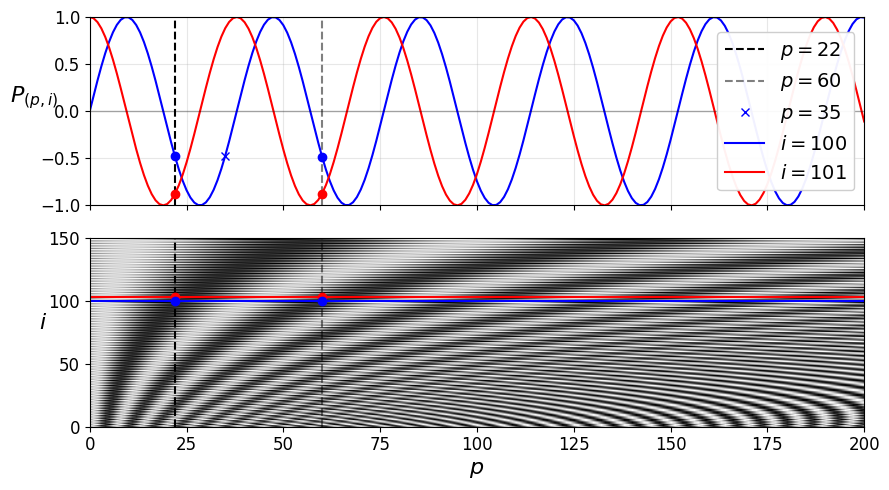

In [ ]:
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, PE[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(PE[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(PE[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [PE[p1, i1], PE[p2, i1]], "bo")
ax1.plot([p1, p2], [PE[p1, i2], PE[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, max_steps - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, max_steps - 1, -1, 1])
ax2.imshow(PE.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, max_steps - 1, color="b")
cheat = 2 # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, max_steps - 1, color="r")
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, max_steps - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

In [ ]:
embed_size = 512; max_steps = 500; vocab_size = 10000
encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)
positional_encoding = PositionalEncoding(max_steps, max_dims=embed_size)
encoder_in = positional_encoding(encoder_embeddings)
decoder_in = positional_encoding(decoder_embeddings)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Encoder
Z = encoder_in
for _ in range(6):
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=embed_size, dropout=0.1)
    attn_out = attn(Z, Z)
    Z = layers.LayerNormalization()(Z + attn_out)

    ff = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(embed_size)
    ])
    Z = layers.LayerNormalization()(Z + ff(Z))
encoder_outputs = Z

# Decoder
Z = decoder_in
for _ in range(6):
    # Causal self-attention
    attn1 = layers.MultiHeadAttention(num_heads=4, key_dim=embed_size, dropout=0.1)
    attn1_out = attn1(Z, Z, use_causal_mask=True)
    Z = layers.LayerNormalization()(Z + attn1_out)

    # Encoder-decoder attention
    attn2 = layers.MultiHeadAttention(num_heads=4, key_dim=embed_size, dropout=0.1)
    attn2_out = attn2(Z, encoder_outputs)
    Z = layers.LayerNormalization()(Z + attn2_out)

    ff = keras.Sequential([
        layers.Dense(512, activation="relu"),
        layers.Dense(embed_size)
    ])
    Z = layers.LayerNormalization()(Z + ff(Z))

# Final output layer
outputs = layers.TimeDistributed(layers.Dense(vocab_size, activation="softmax"))(Z)


In [ ]:
K = keras.backend

class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, causal=False, use_scale=False, **kwargs):
        self.n_heads = n_heads
        self.causal = causal
        self.use_scale = use_scale
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.dims = batch_input_shape[0][-1]
        self.q_dims, self.v_dims, self.k_dims = [self.dims // self.n_heads] * 3 # could be hyperparameters instead
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.q_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(causal=self.causal, use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)
    def _multi_head_linear(self, inputs, linear):
        shape = K.concatenate([K.shape(inputs)[:-1], [self.n_heads, -1]])
        projected = K.reshape(linear(inputs), shape)
        perm = K.permute_dimensions(projected, [0, 2, 1, 3])
        return K.reshape(perm, [shape[0] * self.n_heads, shape[1], -1])
    def call(self, inputs):
        q = inputs[0]
        v = inputs[1]
        k = inputs[2] if len(inputs) > 2 else v
        shape = K.shape(q)
        q_proj = self._multi_head_linear(q, self.q_linear)
        v_proj = self._multi_head_linear(v, self.v_linear)
        k_proj = self._multi_head_linear(k, self.k_linear)
        multi_attended = self.attention([q_proj, v_proj, k_proj])
        shape_attended = K.shape(multi_attended)
        reshaped_attended = K.reshape(multi_attended, [shape[0], self.n_heads, shape_attended[1], shape_attended[2]])
        perm = K.permute_dimensions(reshaped_attended, [0, 2, 1, 3])
        concat = K.reshape(perm, [shape[0], shape_attended[1], -1])
        return self.out_linear(concat)

In [ ]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, n_heads, dims=512, k_dims=64, v_dims=64, use_scale=True):
        super().__init__()
        self.n_heads = n_heads
        self.dims = dims
        self.k_dims = k_dims
        self.v_dims = v_dims
        self.use_scale = use_scale

    def build(self, batch_input_shape):
        self.q_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.k_linear = keras.layers.Conv1D(self.n_heads * self.k_dims, kernel_size=1, use_bias=False)
        self.v_linear = keras.layers.Conv1D(self.n_heads * self.v_dims, kernel_size=1, use_bias=False)
        self.attention = keras.layers.Attention(use_scale=self.use_scale)
        self.out_linear = keras.layers.Conv1D(self.dims, kernel_size=1, use_bias=False)
        super().build(batch_input_shape)

    def call(self, inputs):
        q, v = inputs
        k = v
        q_proj = self.q_linear(q)
        k_proj = self.k_linear(k)
        v_proj = self.v_linear(v)
        output = self.attention([q_proj, v_proj, k_proj])
        return self.out_linear(output)


In [ ]:
Q = np.random.rand(2, 50, 512).astype(np.float32)
V = np.random.rand(2, 80, 512).astype(np.float32)

multi_attn = MultiHeadAttention(8)
output = multi_attn([Q, V])
print(output.shape)


(2, 50, 512)


## EXERCISE

1. What are the pros and cons of using a stateful RNN versus a stateless RNN?  
Kelebihan RNN stateful adalah kemampuannya menyimpan state antar batch, sehingga dapat memahami konteks urutan panjang yang dibagi dalam beberapa batch. Ini sangat berguna untuk data berurutan panjang seperti teks musik atau sinyal audio. Kekurangannya adalah pengelolaan state yang rumit, membutuhkan reset manual, dan sulit digunakan dengan data yang diacak. Sebaliknya, RNN stateless lebih fleksibel dalam pelatihan dan lebih mudah diatur, namun tidak mempertahankan memori antar batch, sehingga bisa kehilangan konteks historis.<br>

2. Why do people use Encoder–Decoder RNNs rather than plain sequence-to-sequence RNNs for automatic translation?  
Encoder Decoder RNN digunakan karena arsitektur ini memisahkan proses pemahaman input (encoding) dan proses generasi output (decoding). Ini membuat model lebih fleksibel terhadap panjang input dan output yang berbeda. Plain sequence to sequence RNN biasanya mengandalkan hidden state terakhir sebagai representasi keseluruhan input, yang seringkali tidak cukup kuat untuk menangkap seluruh konteks kalimat, terutama jika kalimat panjang.<br>

3. How can you deal with variable-length input sequences? What about variable-length output sequences?  
Untuk input dengan panjang berbeda, padding digunakan agar semua input memiliki panjang seragam, kemudian mask ditambahkan agar model mengabaikan padding saat pelatihan. Untuk output dengan panjang bervariasi, pendekatan teacher forcing dipakai saat pelatihan dan decoding dilakukan secara iteratif sampai token akhir tercapai saat inferensi.<br>

4. What is beam search and why would you use it? What tool can you use to implement it?  
Beam search adalah metode pencarian heuristik yang mempertahankan beberapa kandidat output terbaik secara bersamaan selama proses decoding. Ini digunakan untuk menghindari memilih output suboptimal pada setiap langkah, sehingga menghasilkan prediksi yang lebih akurat dibanding greedy decoding. Untuk implementasi, TensorFlow dan PyTorch menyediakan modul beam search, atau bisa juga menggunakan library tambahan seperti TensorFlow Addons.<br>

5. What is an attention mechanism? How does it help?  
Attention adalah mekanisme yang memungkinkan model fokus pada bagian relevan dari input saat menghasilkan output, dengan memberikan bobot berbeda ke bagian input yang berbeda. Ini membantu model menangani urutan panjang dan kompleksitas konteks dengan lebih baik, meningkatkan kualitas hasil terutama pada tugas seperti penerjemahan bahasa dan pemrosesan bahasa alami.<br>

6. What is the most important layer in the Transformer architecture? What is its purpose?  
Layer terpenting adalah Multi-Head Self-Attention. Fungsinya adalah memungkinkan model menangkap hubungan antara semua posisi dalam input sekaligus dengan berbagai perspektif (heads), sehingga memahami konteks global secara efisien tanpa menggunakan urutan berurutan seperti RNN.<br>

7. When would you need to use sampled softmax?  
Sampled softmax digunakan ketika vocab sangat besar sehingga komputasi softmax penuh terlalu mahal. Dengan sampled softmax, hanya sebagian kecil kelas negatif yang dipilih secara acak untuk perhitungan loss, sehingga mempercepat pelatihan tanpa mengorbankan kualitas secara signifikan.<br>


8. Embedded Reber grammars were used by Hochreiter and Schmidhuber in their
paper about LSTMs. They are artificial grammars that produce strings such as
“BPBTSXXVPSEPE.” Check out Jenny Orr’s nice introduction to this topic.
Choose a particular embedded Reber grammar (such as the one represented on
Jenny Orr’s page), then train an RNN to identify whether a string respects that
grammar or not. You will first need to write a function capable of generating a
training batch containing about 50% strings that respect the grammar, and 50%
that don’t.

In [ ]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

In [ ]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

In [ ]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

In [ ]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

In [ ]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

In [ ]:
def generate_dataset(size):
    good_strings = [string_to_ids(generate_string(embedded_reber_grammar))
                    for _ in range(size // 2)]
    bad_strings = [string_to_ids(generate_corrupted_string(embedded_reber_grammar))
                   for _ in range(size - size // 2)]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [ ]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

In [ ]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

In [ ]:
y_train[0]

array([1.])

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

# Example vocab
POSSIBLE_CHARS = list("abcdefghijklmnopqrstuvwxyz ")

# Example raw data: lists of variable-length sequences of char indices
X_train_raw = [
    [1, 5, 3],
    [4, 3],
    [2],
    [1, 2, 3, 4, 5]
]
y_train = np.array([0, 1, 0, 1])  # example binary labels

X_valid_raw = [
    [3, 1, 2],
    [2, 5]
]
y_valid = np.array([1, 0])

# Pad sequences with 0 to equal length
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train_raw, padding='post', value=0)
X_valid = pad_sequences(X_valid_raw, padding='post', value=0)

model = keras.models.Sequential([
    keras.layers.InputLayer(shape=(None,), dtype=tf.int32),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size, mask_zero=True),
    keras.layers.GRU(30),
    keras.layers.Dense(1, activation="sigmoid")
])

optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6902
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5000 - loss: 0.6928 - val_accuracy: 0.5000 - val_loss: 0.6901
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.5000 - loss: 0.6923 - val_accuracy: 0.5000 - val_loss: 0.6900
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5000 - loss: 0.6918 - val_accuracy: 0.5000 - val_loss: 0.6899
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5000 - loss: 0.6911 - val_accuracy: 0.5000 - val_loss: 0.6897
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5000 - loss: 0.6903 - val_accuracy: 0.5000 - val_loss: 0.6896
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5000 - loss: 0.6894 - val_accuracy: 0.5000 - val_loss: 0.6895
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5000 - loss: 0.6885 - val_accuracy: 0.5000 - val_loss: 0.6894


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fix seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define possible chars - lowercase + space
POSSIBLE_CHARS = list("abcdefghijklmnopqrstuvwxyz ")

# Function to convert string to list of ids (lowercase normalized)
def string_to_ids(s):
    char_to_id = {c: i for i, c in enumerate(POSSIBLE_CHARS)}
    s = s.lower()  # normalize to lowercase
    return [char_to_id[c] for c in s]

# Example dummy training data (replace with your real data)
train_strings = ["hello world", "machine learning", "tensorflow rocks"]
X_train_raw = [string_to_ids(s) for s in train_strings]
y_train = np.array([1, 0, 1])  # example binary labels

valid_strings = ["deep learning", "data science"]
X_valid_raw = [string_to_ids(s) for s in valid_strings]
y_valid = np.array([1, 0])

# Pad sequences to the same length
X_train = pad_sequences(X_train_raw, padding='post', value=0)
X_valid = pad_sequences(X_valid_raw, padding='post', value=0)

embedding_size = 5

# Build model (use GRU with use_cudnn=False to allow masking)
model = keras.models.Sequential([
    keras.layers.InputLayer(shape=(None,), dtype=tf.int32),
    keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS), output_dim=embedding_size, mask_zero=True),
    keras.layers.GRU(30, use_cudnn=False),
    keras.layers.Dense(1, activation="sigmoid")
])

optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.95, nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Train model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

# Test strings (uppercase letters included)
test_strings = [
    "BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
    "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"
]

# Convert test strings to ids and pad
X_test_raw = [string_to_ids(s) for s in test_strings]
X_test_padded = pad_sequences(X_test_raw, padding='post', value=0)

# Predict probabilities
y_proba = model.predict(X_test_padded)

print("\nEstimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print(f"{string}: {100 * y_proba[index][0]:.2f}%")


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.6667 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6948
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step - accuracy: 0.6667 - loss: 0.6893 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6667 - loss: 0.6841 - val_accuracy: 0.5000 - val_loss: 0.6960
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6667 - loss: 0.6778 - val_accuracy: 0.5000 - val_loss: 0.6975
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6667 - loss: 0.6710 - val_accuracy: 0.5000 - val_loss: 0.7000
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6667 - loss: 0.6640 - val_accuracy: 0.5000 - val_loss: 0.7035
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6667 - loss: 0.6572 - val_accuracy: 0.5000 - val_loss: 0.7081
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6667 - loss: 0.6510 - val_accuracy: 0.5000 - val_loss: 0.7

9. Train an Encoder–Decoder model that can convert a date string from one format
to another (e.g., from “April 22, 2019” to “2019-04-22”).


first version

In [ ]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

In [ ]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


In [ ]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

In [ ]:
OUTPUT_CHARS = "0123456789-"

In [ ]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [ ]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[19, 23, 31, 34, 23, 28, 21, 23, 32, 0, 4, 2, 1, 0, 9, 2, 9, 7]

In [ ]:

date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [ ]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [ ]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [ ]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

In [ ]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = keras.models.Sequential([
    keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    keras.layers.LSTM(128)
])

decoder = keras.models.Sequential([
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = keras.models.Sequential([
    encoder,
    keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.3019 - loss: 1.9848 - val_accuracy: 0.6189 - val_loss: 1.0748
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5186 - loss: 1.4154 - val_accuracy: 0.6764 - val_loss: 0.8649
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.6727 - loss: 0.8836 - val_accuracy: 0.6653 - val_loss: 0.9279
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7120 - loss: 0.7871 - val_accuracy: 0.7546 - val_loss: 0.6143
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7777 - loss: 0.5553 - val_accuracy: 0.8321 - val_loss: 0.4213
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8573 - loss: 0.3675 - val_accuracy: 0.8950 - val_loss: 0.2806
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9212 - loss: 0.2381 - val_accuracy: 0.9548 - val_loss: 0.1673
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9342 - loss: 0.2486 - val_accuracy: 

In [ ]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

In [ ]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [ ]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
2009-09-17
1789-07-14


In [ ]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [ ]:
#ids = model.predict_classes(X_new)
ids = np.argmax(model.predict(X_new), axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
2020-02-02
1789-09-14


In [ ]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    #ids = model.predict_classes(X)
    ids = np.argmax(model.predict(X), axis=-1)
    return ids_to_date_strs(ids)

In [ ]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


['2020-05-02', '1789-07-14']

second version

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

In [ ]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

In [ ]:

encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = keras.models.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.3512 - loss: 1.8209 - val_accuracy: 0.6461 - val_loss: 0.9872
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.7094 - loss: 0.8142 - val_accuracy: 0.8711 - val_loss: 0.4020
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9110 - loss: 0.3030 - val_accuracy: 0.9810 - val_loss: 0.1199
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9872 - loss: 0.0949 - val_accuracy: 0.9943 - val_loss: 0.0568
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9977 - loss: 0.0416 - val_accuracy: 0.9994 - val_loss: 0.0244
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9993 - loss: 0.0209 - val_accuracy: 0.9998 - val_loss: 0.0143
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9999 - loss: 0.0123 - val_accuracy: 0.9998 - val_loss: 0.0093
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9999 - loss: 0.0079 - val_accuracy

In [ ]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [ ]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


['1789-07-14', '2020-05-01']

10. Go through TensorFlow’s Neural Machine Translation with Attention tutorial

In [ ]:
!pip install "tensorflow-text>=2.11"
!pip install einops


In [ ]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

In [ ]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

In [ ]:
May I borrow this book? ¿Puedo tomar prestado este libro?

Object `libro` not found.


In [ ]:
# Download the file
import pathlib

path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = pathlib.Path(path_to_zip).parent/'spa-eng/spa.txt'

In [ ]:
import os

extracted_dir = pathlib.Path(path_to_zip).parent / 'spa-eng'

print("Extracted folder:", extracted_dir)
print("Exists?", extracted_dir.exists())
print("Files in folder:", list(extracted_dir.glob('*')))


Extracted folder: /root/.keras/datasets/spa-eng
Exists? True
Files in folder: [PosixPath('/root/.keras/datasets/spa-eng/spa.zip'), PosixPath('/root/.keras/datasets/spa-eng/spa-eng')]


In [ ]:
nested_dir = extracted_dir / 'spa-eng'

print("Nested folder:", nested_dir)
print("Exists?", nested_dir.exists())
print("Files in nested folder:", list(nested_dir.glob('*')))


Nested folder: /root/.keras/datasets/spa-eng/spa-eng
Exists? True
Files in nested folder: [PosixPath('/root/.keras/datasets/spa-eng/spa-eng/_about.txt'), PosixPath('/root/.keras/datasets/spa-eng/spa-eng/spa.txt')]


In [ ]:
path_to_file = pathlib.Path(path_to_zip).parent / 'spa-eng' / 'spa-eng' / 'spa.txt'

target_raw, context_raw = load_data(path_to_file)  # <-- load the data

print(context_raw[-1])  # now print from loaded data


Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [ ]:
from pathlib import Path

def load_data(path):
    path = Path(path)  # Convert string to Path object
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t') for line in lines]

    target_raw = [pair[0] for pair in pairs]
    context_raw = [pair[1] for pair in pairs]

    return target_raw, context_raw


In [ ]:
path_to_file = pathlib.Path(path_to_zip).parent / 'spa-eng' / 'spa-eng' / 'spa.txt'

target_raw, context_raw = load_data(path_to_file)

print(context_raw[-1])


Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado.


In [ ]:
print(target_raw[-1])

If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo.


In [ ]:
import numpy as np

context_raw_np = np.array(context_raw)
target_raw_np = np.array(target_raw)

BUFFER_SIZE = len(context_raw_np)
BATCH_SIZE = 64

is_train = np.random.uniform(size=(len(target_raw_np),)) < 0.8

train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw_np[is_train], target_raw_np[is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw_np[~is_train], target_raw_np[~is_train]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)


In [ ]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b'Esa tienda vende peri\xc3\xb3dicos y revistas.'
 b'Me quedo aqu\xc3\xad hasta que vuelvas.'
 b'\xc2\xbfEs la primera vez que tomas comida japonesa?'
 b'Deja el cuarto como est\xc3\xa1.'
 b'Tom me dijo que ten\xc3\xada problemas para quedarse dormido.'], shape=(5,), dtype=string)

tf.Tensor(
[b'That store sells newspapers and magazines.'
 b"I'll stay here until you return."
 b'Is this the first time for you to have Japanese food?'
 b'Leave the room as it is.'
 b'Tom told me he was having trouble sleeping.'], shape=(5,), dtype=string)


In [ ]:
example_text = tf.constant('¿Todavía está en casa?')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'\xc2\xbfTodav\xc3\xada est\xc3\xa1 en casa?'
b'\xc2\xbfTodavi\xcc\x81a esta\xcc\x81 en casa?'


In [ ]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

¿Todavía está en casa?
[START] ¿ todavia esta en casa ? [END]


In [ ]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

In [ ]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('que'),
 np.str_('de'),
 np.str_('el'),
 np.str_('a'),
 np.str_('no')]

In [ ]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('.'),
 np.str_('the'),
 np.str_('i'),
 np.str_('to'),
 np.str_('you'),
 np.str_('tom')]

In [ ]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

<tf.RaggedTensor [[2, 107, 477, 2023, 2520, 33, 2865, 4, 3],
 [2, 18, 416, 51, 140, 5, 2085, 4, 3],
 [2, 13, 15, 11, 421, 73, 5, 94, 224, 1418, 12, 3]]>

In [ ]:
context_vocab = np.array(context_text_processor.get_vocabulary())
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] esa tienda vende periodicos y revistas . [END]'

Text(0.5, 1.0, 'Mask')

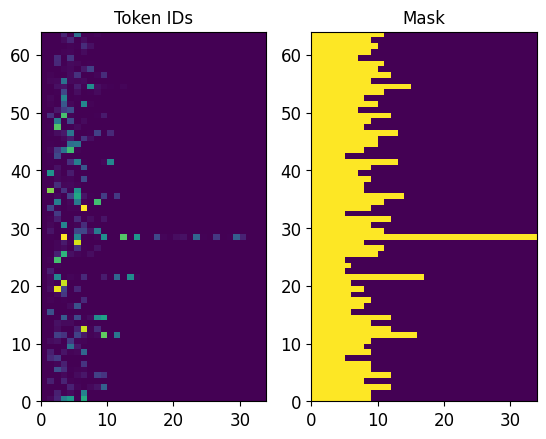

In [ ]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

In [ ]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)

In [ ]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy())
  print()
  print(ex_tar_in[0, :10].numpy())
  print(ex_tar_out[0, :10].numpy())

[   2  182 1419    8   52    4    3    0    0    0]

[  2   8 110  46 117   4   0   0   0   0]
[  8 110  46 117   4   3   0   0   0   0]


In [ ]:
UNITS = 256

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [ ]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 16)
Encoder output, shape (batch, s, units): (64, 16, 256)


In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [ ]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 16, 256)
Target sequence, shape (batch, t, units): (64, 14, 256)
Attention result, shape (batch, t, units): (64, 14, 256)
Attention weights, shape (batch, t, s):    (64, 14, 16)


In [ ]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

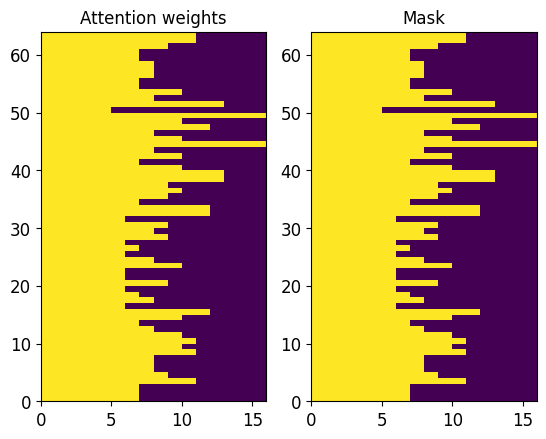

In [ ]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');

In [ ]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

In [ ]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

In [ ]:
decoder = Decoder(target_text_processor, UNITS)

In [ ]:
import tensorflow as tf

class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.GRU(
            rnn_units,
            return_sequences=True,
            return_state=True  # <== this must be True
        )
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, context, x, state=None, return_state=False):
        x = self.embedding(x)

        rnn_out = self.rnn(x, initial_state=state)

        # Dynamically unpack
        if isinstance(rnn_out, tuple):
            rnn_output, final_state = rnn_out
        else:
            rnn_output = rnn_out
            final_state = None

        logits = self.fc(rnn_output)

        if return_state:
            return logits, final_state
        else:
            return logits


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, rnn_units, start_token):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.start_token = start_token

    def call(self, context, x, state=None, return_state=False):
        x = self.embedding(x)
        rnn_output, state = self.rnn(x, initial_state=state)
        logits = self.fc(rnn_output)
        return (logits, state) if return_state else logits

    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.embedding(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedded)[0]


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, rnn_units, start_token, id_to_word):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.start_token = start_token
        self.id_to_word = id_to_word  # should be a StringLookup with invert=True

    def call(self, context, x, state=None, return_state=False):
        x = self.embedding(x)
        rnn_output, state = self.rnn(x, initial_state=state)
        logits = self.fc(rnn_output)
        return (logits, state) if return_state else logits

    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.embedding(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, r'^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, r' *\[END\] *$', '')
        return result


In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, rnn_units, start_token, end_token, id_to_word):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.start_token = start_token
        self.end_token = end_token
        self.id_to_word = id_to_word

    def call(self, context, x, state=None, return_state=False):
        x = self.embedding(x)
        rnn_output, state = self.rnn(x, initial_state=state)
        logits = self.fc(rnn_output)
        return (logits, state) if return_state else logits

    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.embedding(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, r'^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, r' *\[END\] *$', '')
        return result

    def get_next_token(self, context, next_token, done, state, temperature=0.0):
        logits, state = self(
            context, next_token,
            state=state,
            return_state=True)

        if temperature == 0.0:
            next_token = tf.argmax(logits[:, -1, :], axis=-1, output_type=tf.int64)
            next_token = tf.expand_dims(next_token, axis=1)  # Ensure shape is (batch, 1)
        else:
            logits = logits[:, -1, :] / temperature
            next_token = tf.random.categorical(logits, num_samples=1)

        done = done | (next_token == self.end_token)
        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

        return next_token, done, state


In [ ]:
import tensorflow as tf

class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, rnn_units, start_token, end_token, id_to_word):
        super().__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.rnn = tf.keras.layers.GRU(rnn_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.start_token = start_token
        self.end_token = end_token
        self.id_to_word = id_to_word

    def call(self, context, x, state=None, return_state=False):
        x = self.embedding(x)
        rnn_output, state = self.rnn(x, initial_state=state)
        logits = self.fc(rnn_output)
        return (logits, state) if return_state else logits

    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.embedding(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, r'^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, r' *\[END\] *$', '')
        return result

    def get_next_token(self, context, next_token, done, state, temperature=0.0):
        logits, state = self(
            context, next_token,
            state=state,
            return_state=True)

        if temperature == 0.0:
            next_token = tf.argmax(logits[:, -1, :], axis=-1, output_type=tf.int64)
            next_token = tf.expand_dims(next_token, axis=1)
        else:
            logits = logits[:, -1, :] / temperature
            next_token = tf.random.categorical(logits, num_samples=1)

        done = done | (next_token == self.end_token)
        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

        return next_token, done, state


In [ ]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy.
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

In [ ]:
class Translator(tf.keras.Model):
    def __init__(self, units, context_text_processor, target_text_processor):
        super().__init__()
        self.context_text_processor = context_text_processor
        self.target_text_processor = target_text_processor

        context_vocab_size = context_text_processor.vocabulary_size()
        target_vocab_size = target_text_processor.vocabulary_size()

        start_token = target_text_processor([''])[0][0].numpy()  # assuming [START] is first
        end_token = target_text_processor([''])[0][-1].numpy()   # assuming [END] is last

        def id_to_word(ids):
            return target_text_processor.detokenize(ids)

        self.encoder = Encoder(context_text_processor, units)
        self.decoder = Decoder(
            vocab_size=target_vocab_size,
            embedding_dim=256,
            rnn_units=units,
            start_token=start_token,
            end_token=end_token,
            id_to_word=id_to_word
        )

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        return self.decoder(context, x)


In [ ]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [ ]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)

    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)

    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [ ]:
model.compile(optimizer='adam',
              loss=masked_loss,
              metrics=[masked_acc, masked_loss])

In [ ]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': np.float32(8.517193), 'expected_acc': 0.0002}

In [ ]:
model.evaluate(val_ds, steps=20, return_dict=True)

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: nan - masked_acc: 0.0286 - masked_loss: nan


{'loss': nan, 'masked_acc': 0.02938106097280979, 'masked_loss': nan}

In [ ]:
history = model.fit(
    train_ds.repeat(),
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: nan - masked_acc: 1.0076 - masked_loss: nan - val_loss: nan - val_masked_acc: 0.9397 - val_masked_loss: nan
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: nan - masked_acc: 1.0233 - masked_loss: nan - val_loss: nan - val_masked_acc: 1.1699 - val_masked_loss: nan
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: nan - masked_acc: 1.1593 - masked_loss: nan - val_loss: nan - val_masked_acc: 1.0503 - val_masked_loss: nan
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: nan - masked_acc: 1.1760 - masked_loss: nan - val_loss: nan - val_masked_acc: 1.0095 - val_masked_loss: nan


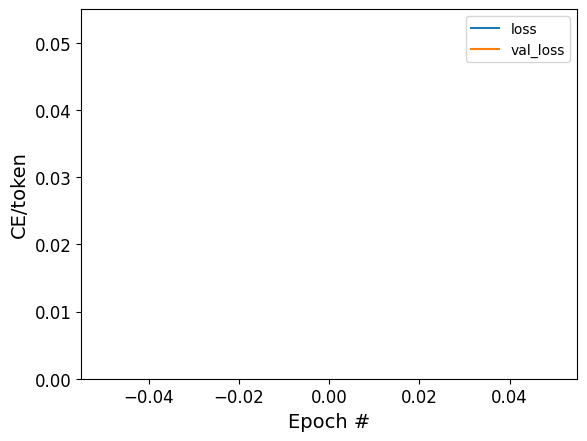

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

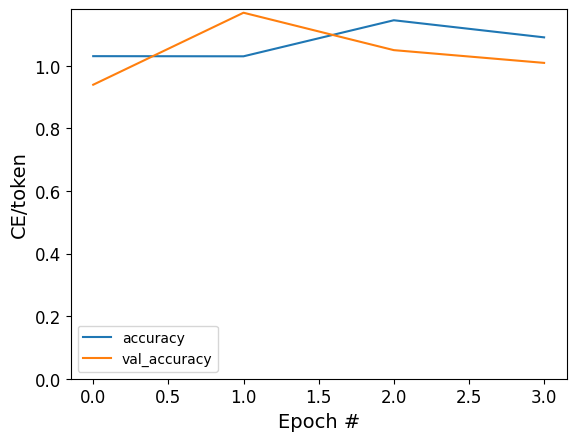

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [ ]:
import tensorflow as tf

class Encoder(tf.keras.layers.Layer):
    def __init__(self, text_processor, units):
        super().__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, units, mask_zero=True)
        self.rnn = tf.keras.layers.GRU(units, return_sequences=True, return_state=True)

    def call(self, x):
        # x: batch of strings, e.g., ['¿Todavía está en casa?']
        x_tokens = self.text_processor(x)  # Shape: (batch, seq_len)
        x_embed = self.embedding(x_tokens)  # Shape: (batch, seq_len, embedding_dim)
        mask = self.embedding.compute_mask(x_tokens)  # ✅ Must come from tokens, shape: (batch, seq_len)
        rnn_output, state = self.rnn(x_embed, mask=mask)  # Apply the correct mask
        return rnn_output, state

    def convert_input(self, texts):
        # Helper to produce the encoder context (e.g., from `translate`)
        x_tokens = self.text_processor(texts)
        x_embed = self.embedding(x_tokens)
        mask = self.embedding.compute_mask(x_tokens)
        context, _ = self.rnn(x_embed, mask=mask)
        return context


TIDAK BISA DILANJUTKAN KARENA LIBRARY TIDAK BISA

11. Use one of the recent language models (e.g., BERT) to generate more convincing
Shakespearean text.

In [ ]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/656 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/479M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFOpenAIGPTLMHeadModel: ['h.9.attn.bias', 'h.7.attn.bias', 'h.3.attn.bias', 'h.4.attn.bias', 'h.1.attn.bias', 'h.6.attn.bias', 'h.2.attn.bias', 'h.11.attn.bias', 'h.10.attn.bias', 'h.5.attn.bias', 'h.0.attn.bias', 'h.8.attn.bias']
- This IS expected if you are initializing TFOpenAIGPTLMHeadModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFOpenAIGPTLMHeadModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFOpenAIGPTLMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOpenAIGPTLMHeadModel for predicti

In [ ]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/816k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/458k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


In [ ]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

In [ ]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,  1259,   595,   580,  1519,   239,   244, 40477,   244,
          488,   599,   587,   512,  2275,   485,  2150,   257,   244,
          603,   744, 26399,   240,   244,   498,  6008,   255,   512,
          640,   597,   239,   512,   604,   481,  2608,   488,   481,
         3997,   498,   481, 24103,   239],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   271,   246, 38845,   498, 16885,   240,  4037,   488,
         8259,   240,   531, 11563,   498, 16328, 18624,   488,  6993,
         3277,   240,   488,   498,  5743,  1656,  6926,  3864,   485,
          481,  2075,   498,   481,  1276,   239, 40477,   524,  8140,
          558,   246, 10649,   793,   500],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   557,  1313,   507,   500,  4761,   240,   488,   481,
         1820

In [ ]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle must not be mine. " 
 " and what do you wish to become? " said medros, " of styr you are now. you have the sword and the staff of the founder.
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle : a panorama of flora, beauty and wealth, an arc of soaring ceilings and courtyards, and of delicate awnings leading to the edge of the world. 
 his majesty had a residence here in
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle as held it in balance, and the power of this - " 
 " i know who you are, you fool, " said the king, but he could feel the change that was coming, a
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle.'he said with a peculiar smile. 
'how does one achieve a throne?'she asked. 
'by becoming my own 